In [73]:
## Standard libraries
import os
import math
import numpy as np
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

/tmp/ipykernel_14191/47578708.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [74]:
import torch
print("Using torch", torch.__version__)

Using torch 1.13.0


In [75]:
torch.manual_seed(42) # Setting the seed

Suppose we have the function:

$$y = \frac{1}{|x|}\sum_i \left[(x_i + 2)^2 + 3\right]$$

with $x$ a 3-element vector. 

Computing the gradient of $y$ with respect to $x$ is straightforward:

In [5]:
x = torch.arange(3, dtype=torch.float32, requires_grad=True)
print(x)
a = x + 2
b = a ** 2
c = b + 3
y = c.mean()

y.backward()

tensor([0., 1., 2.], requires_grad=True)


In [6]:
x.grad

tensor([1.3333, 2.0000, 2.6667])

Indeed if we were to manually calculate the gradient, we would get:

$$\frac{\partial y}{\partial x_i} = \frac{\partial y}{\partial c_i}\frac{\partial c_i}{\partial b_i}\frac{\partial b_i}{\partial a_i}\frac{\partial a_i}{\partial x_i}$$

Note that we have simplified this equation to index notation, and by using the fact that all operation besides the mean do not combine the elements in the tensor. The partial derivatives are:

$$\frac{\partial a_i}{\partial x_i} = 1,\hspace{1cm}
\frac{\partial b_i}{\partial a_i} = 2\cdot a_i\hspace{1cm}
\frac{\partial c_i}{\partial b_i} = 1\hspace{1cm}
\frac{\partial y}{\partial c_i} = \frac{1}{3}$$

So the gradient is:

$$\frac{\partial y}{\partial x} = \frac{2}{3}\left[a_1, a_2, a_3\right]$$

Which is indeed correct

In [7]:
# gpu support checked via
gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")

Is the GPU available? True


In [8]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


In [9]:
# torch makes sending tensors to the GPU relatively easy too
x1 = torch.arange(3, dtype=torch.float32)
x1 = x1.to(device)

# or
x2 = torch.arange(3, dtype=torch.float32, device=device)
print(x1)
print(x2)

tensor([0., 1., 2.], device='cuda:0')
tensor([0., 1., 2.], device='cuda:0')


In [10]:
# GPU operations can have significant performace benefits

x = torch.randn(5000, 5000)

## CPU version
start_time = time.time()
_ = torch.matmul(x, x)
end_time = time.time()
print(f"CPU time: {(end_time - start_time):6.5f}s")

## GPU version
x = x.to(device)
_ = torch.matmul(x, x)  # First operation to 'burn in' GPU
# CUDA is asynchronous, so we need to use different timing functions
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record()
_ = torch.matmul(x, x)
end.record()
torch.cuda.synchronize()  # Waits for everything to finish running on the GPU
print(f"GPU time: {0.001 * start.elapsed_time(end):6.5f}s")  # Milliseconds to seconds

print(f"Speedup: {(end_time - start_time) / (0.001 * start.elapsed_time(end)):.2f}x")
# on beefier GPU, speedup can be 50-100x

CPU time: 0.60350s
GPU time: 0.08740s
Speedup: 6.91x


In [11]:
# seeding random numbers works a bit differently on GPU

# GPU operations have a separate seed we also want to set
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Note that due to different GPU architectures, running the same code on different GPUs does not guarantee the same random numbers.

## Example

### Continuous XOR

In [76]:
import torch.nn as nn
import torch.nn.functional as F

In [13]:
class SimpleClassifier(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x

In [14]:
model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
# Printing a module shows all its submodules
print(model)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)


In [15]:
# The parameters of a module can be obtained by using its parameters() functions, or named_parameters() to get a name to each parameter object. For our small neural network, we have the following parameters:

for name, param in model.named_parameters():
    print(f"Parameter {name}, shape {param.shape}")

Parameter linear1.weight, shape torch.Size([4, 2])
Parameter linear1.bias, shape torch.Size([4])
Parameter linear2.weight, shape torch.Size([1, 4])
Parameter linear2.bias, shape torch.Size([1])


In [77]:
# the data
import torch.utils.data as data

In [17]:
class XORDataset(data.Dataset):
    def __init__(self, size, std_dev=0.1):
        super().__init__()
        self.size = size
        self.std_dev = std_dev
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1) == 1).float()

        # Add noise
        data += torch.randn_like(data) * self.std_dev

        self.data = data
        self.label = label

    def __len__(self):
        return self.size

    def __getitem__(self, index):
        return self.data[index], self.label[index]
        

In [18]:
dataset = XORDataset(size=200)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

Size of dataset: 200
Data point 0: (tensor([1.0275, 0.0544]), tensor(1.))


In [19]:
def visualize_samples(data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

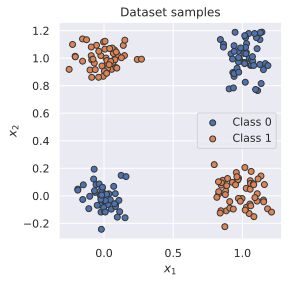

In [20]:
visualize_samples(dataset.data, dataset.label)
plt.show()

In [23]:
# now we will create a data loader to load the data in batches

In [24]:
data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True)

In [25]:
# next(iter(...)) catches the first batch of the data loader
# If shuffle is True, this will return a different batch every time we run this cell
# For iterating over the whole dataset, we can simple use "for batch in data_loader: ..."
data_inputs, data_labels = next(iter(data_loader))

# The shape of the outputs are [batch_size, d_1,...,d_N] where d_1,...,d_N are the
# dimensions of the data point returned from the dataset class
print("Data inputs", data_inputs.shape, "\n", data_inputs)
print("Data labels", data_labels.shape, "\n", data_labels)

Data inputs torch.Size([8, 2]) 
 tensor([[ 0.1131, -0.1150],
        [ 1.1658,  0.9603],
        [ 0.8870,  0.0738],
        [-0.0889,  0.9878],
        [ 0.7967,  0.2268],
        [ 1.0150,  0.9689],
        [ 0.9877,  1.0747],
        [-0.0890,  0.8608]])
Data labels torch.Size([8]) 
 tensor([0., 0., 1., 1., 1., 0., 0., 1.])


In [40]:
loss_module = nn.BCEWithLogitsLoss()
# Input to the optimizer are the parameters of the model: model.parameters()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [41]:
train_dataset = XORDataset(size=2500)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)

In [42]:
# Push model to device. Has to be only done once
model.to(device)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)

In [47]:
def train_model(model, optimizer, data_loader, loss_module, num_epochs=100):
    # set the model to train mode
    model.train()

    # training loop 
    for epoch in tqdm(range(num_epochs)):
        for data_inputs, data_labels in data_loader:
            # Push data to device
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)

            # Forward pass
            predictions = model(data_inputs).squeeze(1)
            loss = loss_module(predictions, data_labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}, loss {loss.item():.2f}")

In [48]:
train_model(model, optimizer, train_data_loader, loss_module, num_epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 10, loss 0.01
Epoch 20, loss 0.01
Epoch 30, loss 0.01
Epoch 40, loss 0.01
Epoch 50, loss 0.01
Epoch 60, loss 0.01
Epoch 70, loss 0.01
Epoch 80, loss 0.01
Epoch 90, loss 0.00
Epoch 100, loss 0.00


In [49]:
# saving a model with pytorch is also very convenient
state_dict = model.state_dict()
print(state_dict)

OrderedDict([('linear1.weight', tensor([[-1.0418,  0.6374],
        [-3.5320, -3.7903],
        [-2.9933, -2.6174],
        [ 1.5149, -1.7753]], device='cuda:0')), ('linear1.bias', tensor([-0.5632,  1.8644,  4.1424, -1.1682], device='cuda:0')), ('linear2.weight', tensor([[ 1.8214, -6.0084,  5.8215,  2.9142]], device='cuda:0')), ('linear2.bias', tensor([-2.5579], device='cuda:0'))])


In [50]:
# to save we use torch.save

torch.save(state_dict, "con_xor.tar")

In [51]:
# to load we use torch.load

l_state_dict = torch.load("con_xor.tar")

new_model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
new_model.load_state_dict(l_state_dict)

# Verify that the parameters are the same
print("Original model\n", model.state_dict())
print("\nLoaded model\n", new_model.state_dict())

Original model
 OrderedDict([('linear1.weight', tensor([[-1.0418,  0.6374],
        [-3.5320, -3.7903],
        [-2.9933, -2.6174],
        [ 1.5149, -1.7753]], device='cuda:0')), ('linear1.bias', tensor([-0.5632,  1.8644,  4.1424, -1.1682], device='cuda:0')), ('linear2.weight', tensor([[ 1.8214, -6.0084,  5.8215,  2.9142]], device='cuda:0')), ('linear2.bias', tensor([-2.5579], device='cuda:0'))])

Loaded model
 OrderedDict([('linear1.weight', tensor([[-1.0418,  0.6374],
        [-3.5320, -3.7903],
        [-2.9933, -2.6174],
        [ 1.5149, -1.7753]])), ('linear1.bias', tensor([-0.5632,  1.8644,  4.1424, -1.1682])), ('linear2.weight', tensor([[ 1.8214, -6.0084,  5.8215,  2.9142]])), ('linear2.bias', tensor([-2.5579]))])


In [52]:
# now we want to evaluate the model
test_dataset = XORDataset(size=500)
# drop_last -> Don't drop the last batch although it is smaller than 128
test_data_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False)

In [55]:
def eval_model(model, data_loader):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.

    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:

            # Determine prediction of model on dev set
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds) # Sigmoid to map predictions between 0 and 1
            pred_labels = (preds >= 0.5).long() # Binarize predictions to 0 and 1

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]

    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

In [56]:
eval_model(model, test_data_loader)

Accuracy of the model: 100.00%


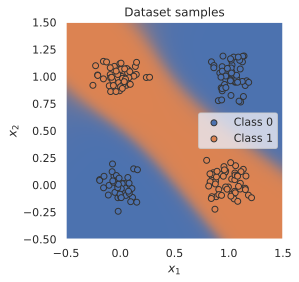

In [59]:
# we can also vizualize the decision boundary of the model
@torch.no_grad() # Decorator, same effect as "with torch.no_grad(): ..." over the whole function.
def visualize_classification(model, data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    fig = plt.figure(figsize=(4,4), dpi=500)
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

    # Let's make use of a lot of operations we have learned above
    model.to(device)
    c0 = torch.Tensor(to_rgba("C0")).to(device)
    c1 = torch.Tensor(to_rgba("C1")).to(device)
    x1 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    x2 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2, indexing='ij')  # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    preds = model(model_inputs)
    preds = torch.sigmoid(preds)
    output_image = (1 - preds) * c0[None,None] + preds * c1[None,None]  # Specifying "None" in a dimension creates a new one
    output_image = output_image.cpu().numpy()  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin='lower', extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)
    return fig

_ = visualize_classification(model, dataset.data, dataset.label)
plt.show()

In [66]:
# Import tensorboard logger from PyTorch
from torch.utils.tensorboard import SummaryWriter

In [79]:
def train_model_with_logger(model, optimizer, data_loader, loss_module, val_dataset, num_epochs=100, logging_dir='./tensorboard_logs/cont_xor'):
    # Create TensorBoard logger
    writer = SummaryWriter(logging_dir)
    model_plotted = False
    model.to(device)

    # Set model to train mode
    model.train()

    # Training loop
    for epoch in tqdm(range(num_epochs)):
        epoch_loss = 0.0
        for data_inputs, data_labels in data_loader:

            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)

            # For the very first batch, we visualize the computation graph in TensorBoard
            if not model_plotted:
                writer.add_graph(model, data_inputs)
                model_plotted = True

            ## Step 2: Run the model on the input data
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]

            ## Step 3: Calculate the loss
            loss = loss_module(preds, data_labels.float())

            ## Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()

            ## Step 5: Update the parameters
            optimizer.step()

            ## Step 6: Take the running average of the loss
            epoch_loss += loss.item()

        # Add average loss to TensorBoard
        epoch_loss /= len(data_loader)
        writer.add_scalar('training_loss',
                          epoch_loss,
                          global_step = epoch + 1)

        # Visualize prediction and add figure to TensorBoard
        # Since matplotlib figures can be slow in rendering, we only do it every 10th epoch
        if (epoch + 1) % 10 == 0:
            fig = visualize_classification(model, val_dataset.data, val_dataset.label)
            writer.add_figure('predictions',
                              fig,
                              global_step = epoch + 1)

    writer.close()

# Create a new model and optimizer
model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train_data = XORDataset(size=5000)
data_loader = data.DataLoader(train_data, batch_size=8, shuffle=True)
loss_module = nn.BCEWithLogitsLoss()
val_dataset = XORDataset(size=1000)

# Train the model
train_model_with_logger(model, optimizer, data_loader, loss_module, val_dataset, num_epochs=100, logging_dir='./tensorboard_logs/cont_xor')


  0%|          | 0/100 [00:00<?, ?it/s]